# Path Setting

In [17]:
import sys

BASE_PATH = "/Users/yangdongjae/Desktop/DeepLearning/link_dl-main/"
sys.path.append(BASE_PATH)

# Module Loading

In [18]:
from _01_code._99_common_utils.utils import get_num_cpu_cores, is_linux, is_windows
import os
from pathlib import Path
import torch
import wandb
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torchvision.transforms.functional import to_tensor
from torch.utils.data.dataset import Subset
from torch.nn.functional import softmax
from torchviz import make_dot
from torchsummary import summary
from datetime import datetime
import argparse
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from datetime import datetime
import os
from _01_code._99_common_utils.utils import strfdelta
from torch.autograd import Variable
import random

# Wandb Login

In [19]:
!wandb login

wandb: Currently logged in as: ydj9805. Use `wandb login --relogin` to force relogin


# Utils

In [20]:
class EarlyStopping:
  """Early stops the training if validation loss doesn't improve after a given patience."""
  def __init__(self, patience=10, delta=0.0001, project_name=None, checkpoint_file_path=None, run_time_str=None):
    self.patience = patience
    self.counter = 0
    self.delta = delta

    self.val_loss_min = None
    self.file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_{run_time_str}.pt"
    )
    self.latest_file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
    )

  def check_and_save(self, new_validation_loss, model):
    early_stop = False

    if self.val_loss_min is None:
      self.val_loss_min = new_validation_loss
      message = f'Early stopping is stated!'
    elif new_validation_loss < self.val_loss_min - self.delta:
      message = f'V_loss decreased ({self.val_loss_min:6.3f} --> {new_validation_loss:6.3f}). Saving model...'
      self.save_checkpoint(new_validation_loss, model)
      self.val_loss_min = new_validation_loss
      self.counter = 0
    else:
      self.counter += 1
      message = f'Early stopping counter: {self.counter} out of {self.patience}'
      if self.counter >= self.patience:
        early_stop = True
        message += " *** TRAIN EARLY STOPPED! ***"

    return message, early_stop

  def save_checkpoint(self, val_loss, model):
    '''Saves model when validation loss decrease.'''
    torch.save(model.state_dict(), self.file_path)
    torch.save(model.state_dict(), self.latest_file_path)
    self.val_loss_min = val_loss


class ClassificationTrainer:
  def __init__(
    self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
    run_time_str, wandb, device, checkpoint_file_path, scheduler = None
  ):
    self.project_name = project_name
    self.model = model
    self.optimizer = optimizer
    self.train_data_loader = train_data_loader
    self.validation_data_loader = validation_data_loader
    self.transforms = transforms
    self.run_time_str = run_time_str
    self.wandb = wandb
    self.device = device
    self.checkpoint_file_path = checkpoint_file_path
    self.scheduler = scheduler

    
    self.loss_fn = nn.CrossEntropyLoss()

  def do_train(self):
    self.model.train()  

    loss_train = 0.0
    num_corrects_train = 0
    num_trained_samples = 0
    num_trains = 0

    for train_batch in self.train_data_loader:
      input_train, target_train = train_batch
      input_train = input_train.to(device=self.device)
      target_train = target_train.to(device=self.device)

      input_train = self.transforms(input_train)

      output_train = self.model(input_train)
      loss = self.loss_fn(output_train, target_train)
      loss_train += loss.item()


      predicted_train = torch.argmax(output_train, dim=1)
      num_corrects_train += torch.sum(torch.eq(predicted_train, target_train)).item()

      num_trained_samples += len(input_train)
      num_trains += 1

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

    train_loss = loss_train / num_trains
    train_accuracy = 100.0 * num_corrects_train / num_trained_samples

    return train_loss, train_accuracy

  def do_validation(self):
    self.model.eval()   

    loss_validation = 0.0
    num_corrects_validation = 0
    num_validated_samples = 0
    num_validations = 0

    with torch.no_grad():
      for validation_batch in self.validation_data_loader:
        input_validation, target_validation = validation_batch
        input_validation = input_validation.to(device=self.device)
        target_validation = target_validation.to(device=self.device)

        input_validation = self.transforms(input_validation)

        output_validation = self.model(input_validation)
        loss_validation += self.loss_fn(output_validation, target_validation).item()

        predicted_validation = torch.argmax(output_validation, dim=1)
        num_corrects_validation += torch.sum(torch.eq(predicted_validation, target_validation)).item()

        num_validated_samples += len(input_validation)
        num_validations += 1

    validation_loss = loss_validation / num_validations
    validation_accuracy = 100.0 * num_corrects_validation / num_validated_samples

    return validation_loss, validation_accuracy

  def train_loop(self):
    early_stopping = EarlyStopping(
      patience=self.wandb.config.early_stop_patience,
      project_name=self.project_name,
      checkpoint_file_path=self.checkpoint_file_path,
      run_time_str=self.run_time_str
    )
    n_epochs = self.wandb.config.epochs
    training_start_time = datetime.now()

    for epoch in range(1, n_epochs + 1):
      train_loss, train_accuracy = self.do_train()

      if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
        validation_loss, validation_accuracy = self.do_validation()

        elapsed_time = datetime.now() - training_start_time
        epoch_per_second = epoch / elapsed_time.seconds

        message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

        print(
          f"[Epoch {epoch:>3}] "
          f"T_loss: {train_loss:6.4f}, "
          f"T_accuracy: {train_accuracy:6.4f} | "
          f"V_loss: {validation_loss:6.4f}, "
          f"V_accuracy: {validation_accuracy:6.4f} | "
          f"{message} | "
          f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
          f"T_speed: {epoch_per_second:4.3f}"
        )

        self.wandb.log({
          "Epoch": epoch,
          "Training loss": train_loss,
          "Training accuracy (%)": train_accuracy,
          "Validation loss": validation_loss,
          "Validation accuracy (%)": validation_accuracy,
          "Training speed (epochs/sec.)": epoch_per_second,
        })

        if early_stop:
          break
        if self.scheduler:
          self.scheduler.step()        

    elapsed_time = datetime.now() - training_start_time
    print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")
    
    
class ClassificationTester:
  def __init__(self, project_name, model, test_data_loader, transforms, checkpoint_file_path):
    self.project_name = project_name
    self.model = model
    self.test_data_loader = test_data_loader
    self.transforms = transforms

    self.latest_file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
    )

    print("MODEL FILE: {0}".format(self.latest_file_path))

    self.model.load_state_dict(torch.load(self.latest_file_path, map_location=torch.device('cpu')))

  def test(self):
    self.model.eval()    

    num_corrects_test = 0
    num_tested_samples = 0

    with torch.no_grad():
      for test_batch in self.test_data_loader:
        input_test, target_test = test_batch

        input_test = self.transforms(input_test)

        output_test = self.model(input_test)

        predicted_test = torch.argmax(output_test, dim=1)
        num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

        num_tested_samples += len(input_test)

      test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

  def test_single(self, input_test):
    self.model.eval()    

    with torch.no_grad():
      input_test = self.transforms(input_test)

      output_test = self.model(input_test)
      predicted_test = torch.argmax(output_test, dim=1)

    return predicted_test.item()



# Args

## whole models hyper parameters is below.

batch size : 2048 <br/>
epochs : 2500 <br/>
lr : 1e-3 <br/>
early_stop patience : 10

In [21]:
def get_parser():
  parser = argparse.ArgumentParser()

  parser.add_argument(
    "--wandb", action=argparse.BooleanOptionalAction, default=True, help="True or False"
  )

  parser.add_argument(
    "-b", "--batch_size", type=int, default=2_048, help="Batch size (int, default: 2_048)"
  )

  parser.add_argument(
    "-e", "--epochs", type=int, default=2_500, help="Number of training epochs (int, default:10_000)"
  )

  parser.add_argument(
    "-r", "--learning_rate", type=float, default=1e-3, help="Learning rate (float, default: 1e-3)"
  )

  parser.add_argument(
    "-v", "--validation_intervals", type=int, default=10,
    help="Number of training epochs between validations (int, default: 10)"
  )

  parser.add_argument(
    "-p", "--early_stop_patience", type=int, default=10,
    help="Number of early stop patience (int, default: 10)"
  )

  return parser


## Lecture's Approach to get Train Data

In [22]:
def get_mean_std(imgs):
  mean = imgs.view(1, -1).mean(dim = -1)
  std = imgs.view(1, -1).std(dim = -1)

  return mean, std

def get_fashion_mnist_data():
  data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

  f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
  f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

  print("Num Train Samples: ", len(f_mnist_train))
  print("Num Validation Samples: ", len(f_mnist_validation))
  print("Sample Shape: ", f_mnist_train[0][0].shape)  # torch.Size([1, 28, 28])

  num_data_loading_workers = get_num_cpu_cores() if is_linux() or is_windows() else 0
  print("Number of Data Loading Workers:", num_data_loading_workers)

  train_data_loader = DataLoader(
    dataset=f_mnist_train,
     batch_size=wandb.config.batch_size,
     shuffle=True,
    pin_memory=True,
     num_workers=num_data_loading_workers,
     drop_last = True
  )

  validation_data_loader = DataLoader(
    dataset=f_mnist_validation,
     batch_size=wandb.config.batch_size,
     pin_memory=True,
     num_workers=num_data_loading_workers,
     drop_last = True
  )

  imgs = torch.stack([img_t for img_t, _ in train_data_loader], dim = 3)
  x, y = get_mean_std(imgs)

  f_mnist_transforms = nn.Sequential(
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=x, std=y),
  )

  return train_data_loader, validation_data_loader, f_mnist_transforms


## My Approach to get Train Data

문제1 answer is below

In [23]:
def my_get_fashion_mnist_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    temp_transform = transforms.Compose([
        transforms.ToTensor()
    ])

    temp_dataset = datasets.FashionMNIST(data_path, train=True, download=True, transform=temp_transform)

    # [문제1] PinPoint mean and std values for Fashion MNIST data normalization 
    data_loader_for_calc = DataLoader(temp_dataset, batch_size=len(temp_dataset), shuffle=False)
    data = next(iter(data_loader_for_calc))[0]
    mean = data.mean()
    std = data.std()

    # [Requirements][key points] : Key point of this codes that using Data augmentation with random Horizontal Flip and Rotation, etc. 
    my_f_mnist_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(2.0),
        transforms.RandomAffine(degrees=0, shear=0.2),
        transforms.RandomResizedCrop((28, 28), scale=(0.8, 1.0), ratio=(0.75, 1.33)),
        transforms.RandomCrop(28, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((mean,), (std,))
    ])

    f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=my_f_mnist_transforms)
    f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

    num_data_loading_workers = get_num_cpu_cores() if is_linux() or is_windows() else 0

    my_train_data_loader = DataLoader(
        dataset=f_mnist_train,
        batch_size=wandb.config.batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=num_data_loading_workers,
        drop_last=True)

    my_validation_data_loader = DataLoader(
        dataset=f_mnist_validation,
        batch_size=wandb.config.batch_size,
        pin_memory=True,
        num_workers=num_data_loading_workers,
        drop_last=True)

    print("Num Train Samples: ", len(f_mnist_train))
    print("Num Validation Samples: ", len(f_mnist_validation))
    print("Sample Shape: ", f_mnist_train[0][0].shape)
    print("Number of Data Loading Workers:", num_data_loading_workers)

    return my_train_data_loader, my_validation_data_loader, my_f_mnist_transforms

# Get Test Data

In [24]:
def get_fashion_mnist_test_data():
  data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

  f_mnist_test_images = datasets.FashionMNIST(data_path, train=False, download=True)
  f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

  print("Num Test Samples: ", len(f_mnist_test))
  print("Sample Shape: ", f_mnist_test[0][0].shape)  # torch.Size([1, 28, 28])

  test_data_loader = DataLoader(dataset=f_mnist_test, batch_size=len(f_mnist_test))

  imgs = torch.stack([img_t for img_t, _ in test_data_loader], dim = 3)
  x, y = get_mean_std(imgs)

  f_mnist_transforms = nn.Sequential(
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=x, std=y),
  )

  return f_mnist_test_images, test_data_loader, f_mnist_transforms

# Load Train/Test Data

In [25]:
config = {'batch_size': 2048,}
wandb.init(mode="disabled", config=config)

my_train_data_loader, my_validation_data_loader, my_f_mnist_transforms = my_get_fashion_mnist_data()
print()
my_f_mnist_test_images, my_test_data_loader, my_f_mnist_transforms = get_fashion_mnist_test_data()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape:  torch.Size([1, 28, 28])
Number of Data Loading Workers: 0

Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])


# My Model(4Conv+2FC+pooling+dropout+BN)

In [26]:
def get_my_model():
    class CNNModel5(nn.Module):
        def __init__(self):
            super(CNNModel5, self).__init__()
            self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding='same')
            self.bn1 = nn.BatchNorm2d(64)
            self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding='same')
            self.pool1 = nn.MaxPool2d(kernel_size=2)
            self.dropout1 = nn.Dropout(0.25)

            self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
            self.bn2 = nn.BatchNorm2d(128)
            self.dropout2 = nn.Dropout(0.5)

            self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding='same')
            self.pool2 = nn.MaxPool2d(kernel_size=2)
            self.dropout3 = nn.Dropout(0.5)

            self.flatten = nn.Flatten()
            self.fc1 = nn.Linear(256 * 7 * 7, 256)  
            self.bn3 = nn.BatchNorm1d(256)
            self.dropout4 = nn.Dropout(0.5)
            self.fc2 = nn.Linear(256, 10)

        def forward(self, x):
            x = F.relu(self.bn1(self.conv1(x)))
            x = F.relu(self.conv2(x))
            x = self.pool1(x)
            x = self.dropout1(x)

            x = F.relu(self.bn2(self.conv3(x)))
            x = self.dropout2(x)

            x = F.relu(self.conv4(x))
            x = self.pool2(x)
            x = self.dropout3(x)

            x = self.flatten(x)
            x = F.relu(self.bn3(self.fc1(x)))
            x = self.dropout4(x)
            x = F.log_softmax(self.fc2(x), dim=1)
            return x

    my_model = CNNModel5()
    return my_model

In [27]:
def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
    run_time_str += '-4Conv+2FC+pooling+dropout+BN'
    config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience
    }

    project_name = 'Fashion_MNIST'
    wandb.init(
        mode = "online" if args.wandb else "disabled",
        project = project_name,
        notes = "Assignment #3 with Fashion MNIST dataset",
        tags = ["ComputerVision", "ImageClassification","CNN"],
        name = run_time_str,
        config = config
    )

    print(args)
    print(wandb.config)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
    print(f"Training on Device {device}")

    train_data_loader, validation_data_loader, mnist_transforms = get_fashion_mnist_data()
    model = get_my_model()
    model.to(device)
    wandb.watch(model)

    optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1) 

    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, mnist_transforms,
        run_time_str, wandb, device, checkpoint_file_path='/Users/yangdongjae/Desktop/DeepLearning/link_dl-main/_02_homeworks/_03_fashion_mnist/checkpoints/4Conv+2FC+pooling+dropout+BN'
    )

    classification_trainer.train_loop()

    wandb.finish()

In [28]:
model = get_my_model()
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
       BatchNorm2d-2           [-1, 64, 28, 28]             128
            Conv2d-3           [-1, 64, 28, 28]          36,928
         MaxPool2d-4           [-1, 64, 14, 14]               0
           Dropout-5           [-1, 64, 14, 14]               0
            Conv2d-6          [-1, 128, 14, 14]          73,856
       BatchNorm2d-7          [-1, 128, 14, 14]             256
           Dropout-8          [-1, 128, 14, 14]               0
            Conv2d-9          [-1, 256, 14, 14]         295,168
        MaxPool2d-10            [-1, 256, 7, 7]               0
          Dropout-11            [-1, 256, 7, 7]               0
          Flatten-12                [-1, 12544]               0
           Linear-13                  [-1, 256]       3,211,520
      BatchNorm1d-14                  [

# Make Graph

In [29]:
model.eval()  
input_tensor = torch.tensor(np.array(my_f_mnist_test_images[0][0])).unsqueeze(dim=0).unsqueeze(dim=0).float()
dot = make_dot(model(input_tensor), params=dict(model.named_parameters()))
dot.render("4Conv+2FC+pooling+dropout+BN", format="png")
model.train()  


CNNModel5(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=12544, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (

![](/Users/yangdongjae/Desktop/DeepLearning/link_dl-main/_02_homeworks/_03_fashion_mnist/4Conv+2FC+pooling+dropout+BN.png)

In [39]:
parser = get_parser()
args,_ = parser.parse_known_args()
main(args)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
wandb: ERROR Control-C detected -- Run data was not synced


Namespace(wandb=True, batch_size=2048, epochs=2500, learning_rate=0.001, validation_intervals=10, early_stop_patience=10)
{'epochs': 2500, 'batch_size': 2048, 'validation_intervals': 10, 'learning_rate': 0.001, 'early_stop_patience': 10}
Training on Device mps
Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape:  torch.Size([1, 28, 28])
Number of Data Loading Workers: 0


MODEL FILE: /Users/yangdongjae/Desktop/DeepLearning/link_dl-main/_02_homeworks/_03_fashion_mnist/checkpoints/4Conv_2FC_pooling_dropout_BN/Fashion_MNIST_checkpoint_latest.pt


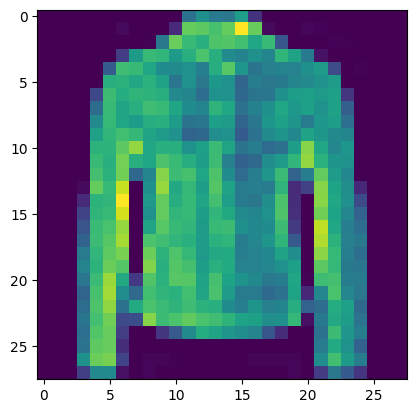

LABEL: 4
PREDICTION: 6
Misclassification detected. Analysis:


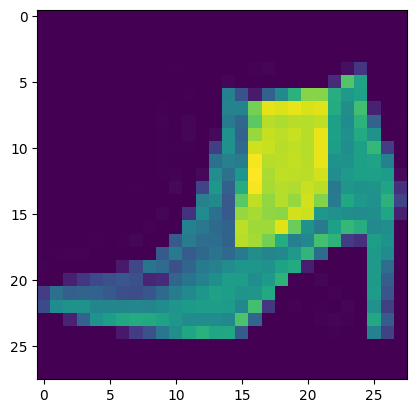

LABEL: 9
PREDICTION: 9


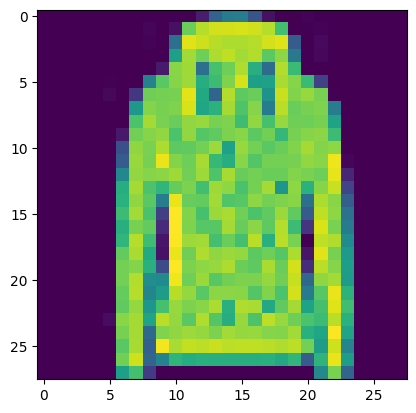

LABEL: 2
PREDICTION: 2


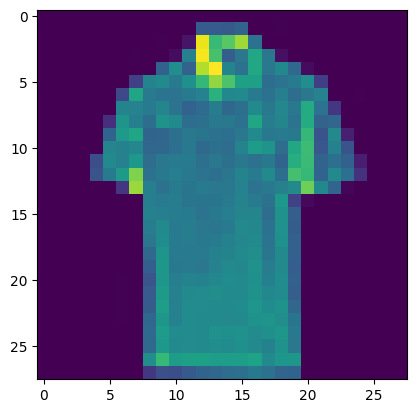

LABEL: 0
PREDICTION: 0


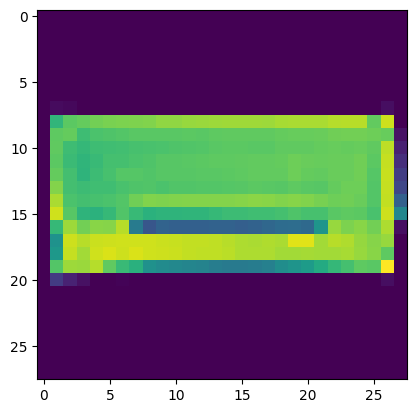

LABEL: 8
PREDICTION: 8


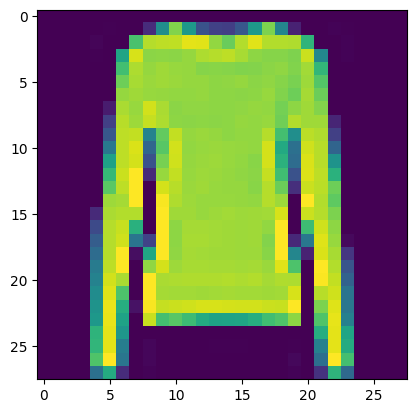

LABEL: 2
PREDICTION: 2


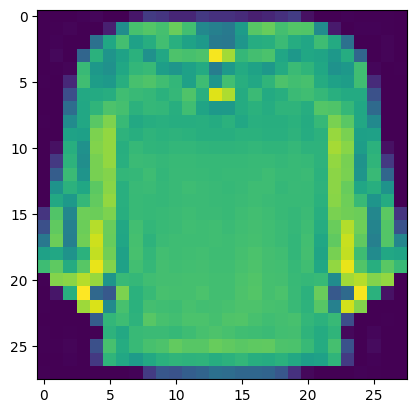

LABEL: 6
PREDICTION: 6


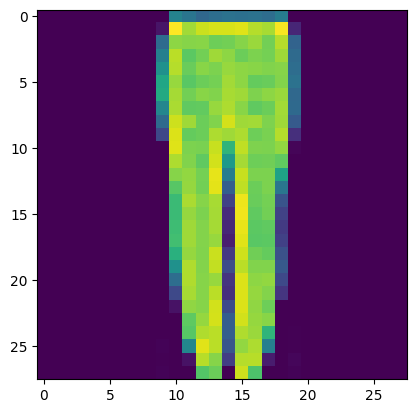

LABEL: 1
PREDICTION: 1


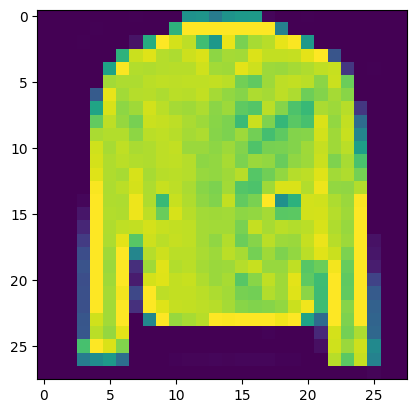

LABEL: 4
PREDICTION: 4


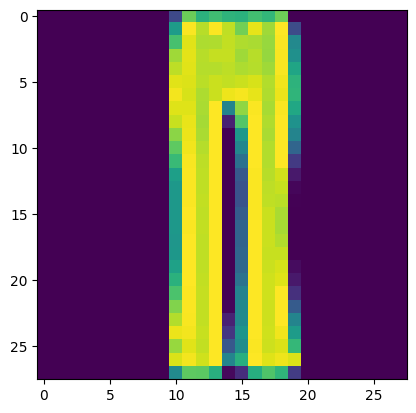

LABEL: 1
PREDICTION: 1


In [31]:
CHECKPOINT_FILE_PATH ='/Users/yangdongjae/Desktop/DeepLearning/link_dl-main/_02_homeworks/_03_fashion_mnist/checkpoints/4Conv_2FC_pooling_dropout_BN/'

test_model = get_my_model()
classification_tester = ClassificationTester(
    'Fashion_MNIST', test_model, my_test_data_loader, my_f_mnist_transforms, CHECKPOINT_FILE_PATH
)

random_indices = random.sample(range(len(my_f_mnist_test_images)), 10)

for idx in random_indices:
    img, label = my_f_mnist_test_images[idx]
    plt.imshow(img)
    plt.show()
    print("LABEL:", label)


    img_tensor = torch.tensor(np.array(img)).unsqueeze(dim=0).unsqueeze(dim=0)


    output = classification_tester.test_single(img_tensor)
    print("PREDICTION:", output)


    if label != output:
        print("Misclassification detected. Analysis:")

# 3Conv+1FC+pooling+l2+BN&learningdecay Model

In [32]:
def get_my_model():
    class CNNModel4(nn.Module):
        def __init__(self):
            super(CNNModel4, self).__init__()
            self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding='same')
            self.bn1 = nn.BatchNorm2d(64)
            self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding='same')
            self.pool = nn.MaxPool2d(kernel_size=2)
            self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
            self.bn2 = nn.BatchNorm2d(128)
            self.flatten = nn.Flatten()
            self.fc1 = nn.Linear(128 * 14 * 14, 128)
            self.bn3 = nn.BatchNorm1d(128)
            self.fc2 = nn.Linear(128, 10)

        def forward(self, x):
            x = F.relu(self.bn1(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = F.relu(self.bn2(self.conv3(x)))
            x = self.flatten(x)
            x = F.relu(self.bn3(self.fc1(x)))
            x = F.softmax(self.fc2(x), dim=1)
            return x

    my_model = CNNModel4()

    return my_model


In [33]:
def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
    run_time_str += '-3Conv+1FC+pooling+l2+BN&learningdecay'
    config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience
    }

    project_name = 'Fashion_MNIST'
    wandb.init(
        mode = "online" if args.wandb else "disabled",
        project = project_name,
        notes = "Assignment #3 with Fashion MNIST dataset",
        tags = ["ComputerVision", "ImageClassification","CNN"],
        name = run_time_str,
        config = config
    )

    print(args)
    print(wandb.config)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
    print(f"Training on Device {device}")

    train_data_loader, validation_data_loader, mnist_transforms = get_fashion_mnist_data()
    model = get_my_model()
    model.to(device)
    wandb.watch(model)

    optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) 

    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, mnist_transforms,
        run_time_str, wandb, device, checkpoint_file_path='/Users/yangdongjae/Desktop/DeepLearning/link_dl-main/_02_homeworks/_03_fashion_mnist/checkpoints/Conv+1FC+pooling+l2+BN&learningdecay',scheduler= scheduler
    )

    classification_trainer.train_loop()

    wandb.finish()

In [34]:
model = get_my_model()
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
       BatchNorm2d-2           [-1, 64, 28, 28]             128
            Conv2d-3           [-1, 64, 28, 28]          36,928
         MaxPool2d-4           [-1, 64, 14, 14]               0
            Conv2d-5          [-1, 128, 14, 14]          73,856
       BatchNorm2d-6          [-1, 128, 14, 14]             256
           Flatten-7                [-1, 25088]               0
            Linear-8                  [-1, 128]       3,211,392
       BatchNorm1d-9                  [-1, 128]             256
           Linear-10                   [-1, 10]           1,290
Total params: 3,324,746
Trainable params: 3,324,746
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.82
Params size (MB): 12.68
Estima

In [35]:
model.eval()  
input_tensor = torch.tensor(np.array(my_f_mnist_test_images[0][0])).unsqueeze(dim=0).unsqueeze(dim=0).float()
dot = make_dot(model(input_tensor), params=dict(model.named_parameters()))
dot.render("3Conv+1FC+pooling+l2+BN&learningdecay", format="png")
model.train()  


CNNModel4(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=25088, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

![](./3Conv+1FC+pooling+l2+BN&learningdecay.png)

In [ ]:
parser = get_parser()
args,_ = parser.parse_known_args()
main(args)

wandb: Currently logged in as: ydj9805. Use `wandb login --relogin` to force relogin


Namespace(wandb=True, batch_size=2048, epochs=2500, learning_rate=0.001, validation_intervals=10, early_stop_patience=10)
{'epochs': 2500, 'batch_size': 2048, 'validation_intervals': 10, 'learning_rate': 0.001, 'early_stop_patience': 10}
Training on Device mps
Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape:  torch.Size([1, 28, 28])
Number of Data Loading Workers: 0
[Epoch   1] T_loss: 1.8060, T_accuracy: 76.6433 | V_loss: 1.7926, V_accuracy: 85.6934 | Early stopping is stated! | T_time: 00:00:10, T_speed: 0.100
[Epoch  10] T_loss: 1.4947, T_accuracy: 97.3915 | V_loss: 1.5420, V_accuracy: 92.7002 | V_loss decreased ( 1.793 -->  1.542). Saving model... | T_time: 00:01:32, T_speed: 0.109
[Epoch  20] T_loss: 1.4713, T_accuracy: 99.1530 | V_loss: 1.5339, V_accuracy: 93.1396 | V_loss decreased ( 1.542 -->  1.534). Saving model... | T_time: 00:03:02, T_speed: 0.110
[Epoch  30] T_loss: 1.4675, T_accuracy: 99.4122 | V_loss: 1.5317, V_accuracy: 93.1885 | V_loss decreased ( 

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Training accuracy (%),▁▇██████████████████
Training loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▇██▇▇▇▇▇▇▇▇▇▇██████
Validation accuracy (%),▁▇██████████████████
Validation loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,190
Training accuracy (%),99.57181
Training loss,1.46547
Training speed (epochs/sec.),0.10945
Validation accuracy (%),93.26172


MODEL FILE: /Users/yangdongjae/Desktop/DeepLearning/link_dl-main/_02_homeworks/_03_fashion_mnist/checkpoints/3Conv+1FC+pooling+l2+BN&learningdecay/Fashion_MNIST_checkpoint_latest.pt


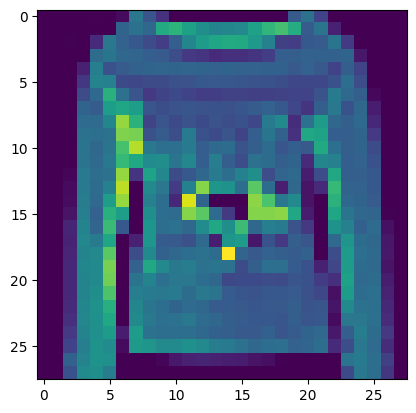

LABEL: 2
PREDICTION: 2


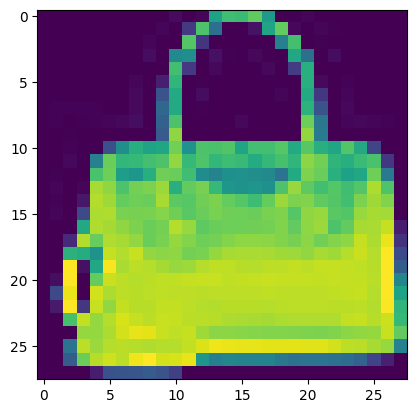

LABEL: 8
PREDICTION: 8


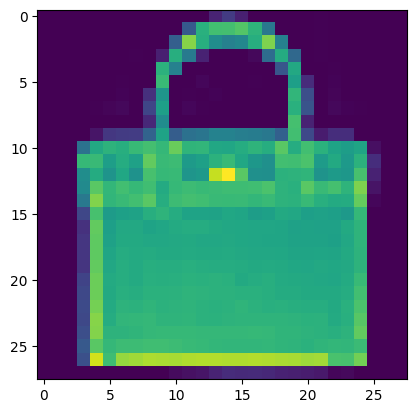

LABEL: 8
PREDICTION: 8


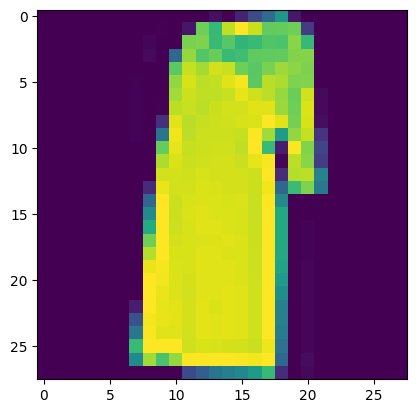

LABEL: 3
PREDICTION: 3


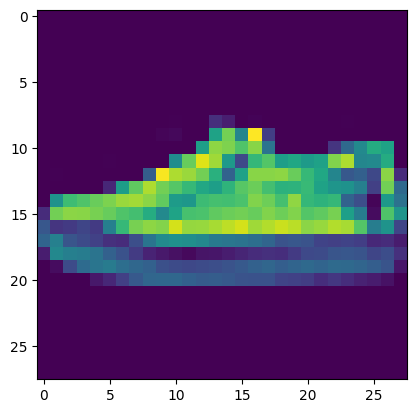

LABEL: 7
PREDICTION: 7


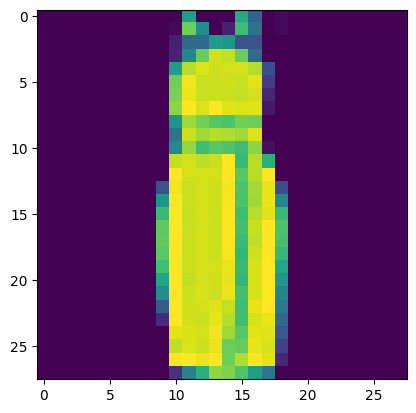

LABEL: 3
PREDICTION: 3


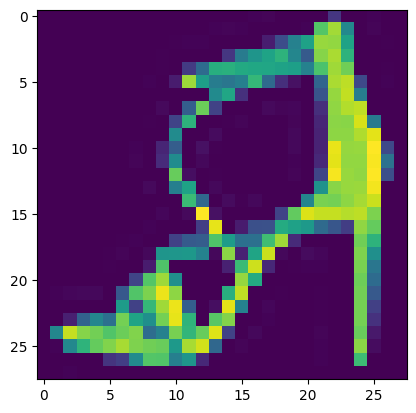

LABEL: 5
PREDICTION: 5


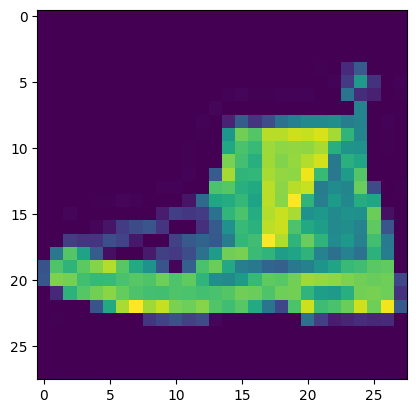

LABEL: 9
PREDICTION: 9


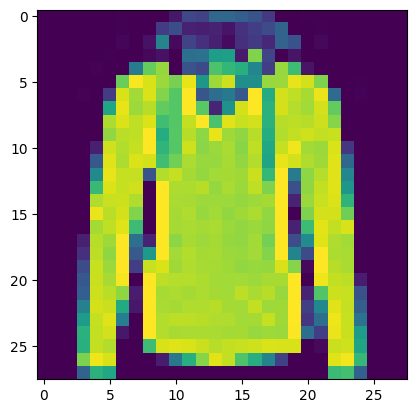

LABEL: 4
PREDICTION: 2
Misclassification detected. Analysis:


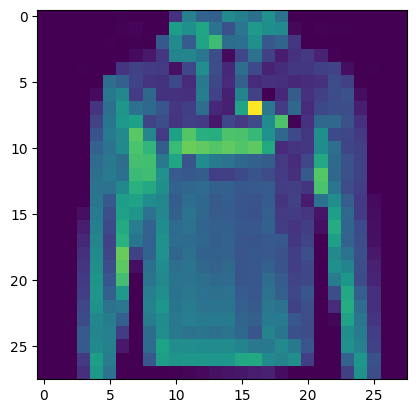

LABEL: 2
PREDICTION: 2


In [36]:
CHECKPOINT_FILE_PATH ='/Users/yangdongjae/Desktop/DeepLearning/link_dl-main/_02_homeworks/_03_fashion_mnist/checkpoints/3Conv+1FC+pooling+l2+BN&learningdecay'

test_model = get_my_model()
classification_tester = ClassificationTester(
    'Fashion_MNIST', test_model, my_test_data_loader, my_f_mnist_transforms, CHECKPOINT_FILE_PATH
)

random_indices = random.sample(range(len(my_f_mnist_test_images)), 10)

for idx in random_indices:
    img, label = my_f_mnist_test_images[idx]
    plt.imshow(img)
    plt.show()
    print("LABEL:", label)


    img_tensor = torch.tensor(np.array(img)).unsqueeze(dim=0).unsqueeze(dim=0)


    output = classification_tester.test_single(img_tensor)
    print("PREDICTION:", output)


    if label != output:
        print("Misclassification detected. Analysis:")

# GoogleNet ADAM Lr Decay

In [37]:
def get_my_model():
    class InceptionModule(nn.Module):
        def __init__(self, in_channels):
            super(InceptionModule, self).__init__()

            
            self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=1)
            self.bn1 = nn.BatchNorm2d(64)

            
            self.conv3 = nn.Conv2d(in_channels, 128, kernel_size=3, padding=1)
            self.bn3 = nn.BatchNorm2d(128)

            
            self.conv5 = nn.Conv2d(in_channels, 32, kernel_size=5, padding=2)
            self.bn5 = nn.BatchNorm2d(32)

            
            self.pool = nn.MaxPool2d(3, stride=1, padding=1)
            self.conv_pool = nn.Conv2d(in_channels, 32, kernel_size=1)
            self.bn_pool = nn.BatchNorm2d(32)

        def forward(self, x):
            x1 = F.relu(self.bn1(self.conv1(x)))
            x3 = F.relu(self.bn3(self.conv3(x)))
            x5 = F.relu(self.bn5(self.conv5(x)))
            xp = F.relu(self.bn_pool(self.conv_pool(self.pool(x))))

            return torch.cat([x1, x3, x5, xp], dim=1)

    class MyGoogleNet(nn.Module):
        def __init__(self, num_classes):
            super(MyGoogleNet, self).__init__()
            self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
            self.bn1 = nn.BatchNorm2d(64)
            self.pool1 = nn.MaxPool2d(3, stride=2, padding=1)

            
            self.inception1 = InceptionModule(64)
            self.inception2 = InceptionModule(256)  

            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.fc = nn.Linear(256, num_classes)  

        def forward(self, x):
            x = F.relu(self.bn1(self.conv1(x)))
            x = self.pool1(x)
            x = self.inception1(x)
            x = self.inception2(x)
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)
            return x

    my_google_net = MyGoogleNet(10)
    return my_google_net


In [38]:
def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
    run_time_str = run_time_str + 'GOOGLENET_BN_ADAM'

    config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience
    }

    project_name = 'Fashion_MNIST'
    wandb.init(
        mode = "online" if args.wandb else "disabled",
        project = project_name,
        notes = "Assignment #3 with Fashion MNIST dataset",
        tags = ["ComputerVision", "ImageClassification","CNN"],
        name = run_time_str,
        config = config
    )

    print(args)
    print(wandb.config)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on Device {device}")

    train_data_loader, validation_data_loader, mnist_transforms = get_fashion_mnist_data()
    model = get_my_model()
    model.to(device)
    wandb.watch(model)

    optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1) 

    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, mnist_transforms,
        run_time_str, wandb, device, checkpoint_file_path='/Users/yangdongjae/Desktop/DeepLearning/link_dl-main/_02_homeworks/_03_fashion_mnist/checkpoints/GoogleNetAdam', scheduler=scheduler
    )

    classification_trainer.train_loop()

    wandb.finish()

In [39]:
model = get_my_model()
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,200
       BatchNorm2d-2           [-1, 64, 14, 14]             128
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4             [-1, 64, 7, 7]           4,160
       BatchNorm2d-5             [-1, 64, 7, 7]             128
            Conv2d-6            [-1, 128, 7, 7]          73,856
       BatchNorm2d-7            [-1, 128, 7, 7]             256
            Conv2d-8             [-1, 32, 7, 7]          51,232
       BatchNorm2d-9             [-1, 32, 7, 7]              64
        MaxPool2d-10             [-1, 64, 7, 7]               0
           Conv2d-11             [-1, 32, 7, 7]           2,080
      BatchNorm2d-12             [-1, 32, 7, 7]              64
  InceptionModule-13            [-1, 256, 7, 7]               0
           Conv2d-14             [-1, 6

In [40]:
model.eval()  
input_tensor = torch.tensor(np.array(my_f_mnist_test_images[0][0])).unsqueeze(dim=0).unsqueeze(dim=0).float()
dot = make_dot(model(input_tensor), params=dict(model.named_parameters()))
dot.render("GoogleNet_Adam", format="png")
model.train()  


MyGoogleNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception1): InceptionModule(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (conv_pool): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (bn_pool): BatchNorm2d(32, eps=1e-05, momentum=0.

![](./GoogleNet_Adam.png)

In [15]:
parser = get_parser()
args,_ = parser.parse_known_args()
main(args)

Namespace(wandb=True, batch_size=2048, epochs=2500, learning_rate=0.001, validation_intervals=10, early_stop_patience=10)
{'epochs': 2500, 'batch_size': 2048, 'validation_intervals': 10, 'learning_rate': 0.001, 'early_stop_patience': 10}
Training on Device cpu
Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape:  torch.Size([1, 28, 28])
Number of Data Loading Workers: 0
[Epoch   1] T_loss: 1.0613, T_accuracy: 67.9312 | V_loss: 0.7535, V_accuracy: 75.5127 | Early stopping is stated! | T_time: 00:02:29, T_speed: 0.007
[Epoch  10] T_loss: 0.2594, T_accuracy: 90.6720 | V_loss: 0.6088, V_accuracy: 80.2490 | V_loss decreased ( 0.754 -->  0.609). Saving model... | T_time: 00:25:17, T_speed: 0.007
[Epoch  20] T_loss: 0.1871, T_accuracy: 93.1284 | V_loss: 0.3305, V_accuracy: 88.4521 | V_loss decreased ( 0.609 -->  0.331). Saving model... | T_time: 00:50:35, T_speed: 0.007
[Epoch  30] T_loss: 0.1371, T_accuracy: 95.1472 | V_loss: 0.3282, V_accuracy: 88.6230 | V_loss decreased ( 

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epoch,▁▁▂▃▃▄▄▅▅▆▆▇▇█
Training accuracy (%),▁▆▇▇▇█████████
Training loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▂▁▁▃▄▅▆▇▇▇▇███
Validation accuracy (%),▂▄▇▇▅▆▆▇▅▁████
Validation loss,▃▂▁▁▂▂▂▂▃█▁▁▁▂
Epoch,130
Training accuracy (%),100.0
Training loss,0.00069
Training speed (epochs/sec.),0.00734
Validation accuracy (%),90.84473


MODEL FILE: /Users/yangdongjae/Desktop/DeepLearning/link_dl-main/_02_homeworks/_03_fashion_mnist/checkpoints/GoogleNetAdam/Fashion_MNIST_checkpoint_latest.pt


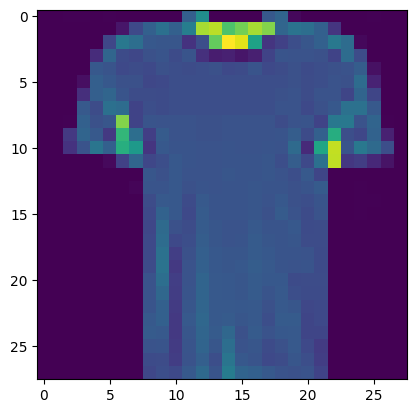

LABEL: 0
PREDICTION: 0


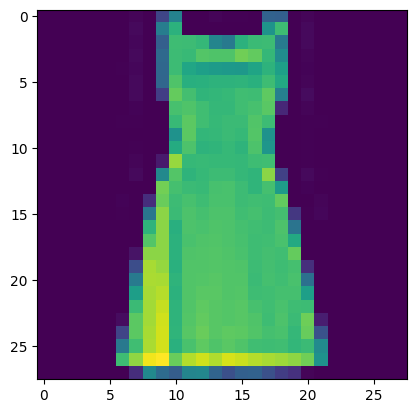

LABEL: 3
PREDICTION: 3


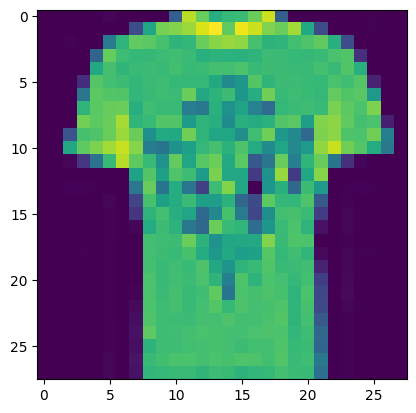

LABEL: 0
PREDICTION: 0


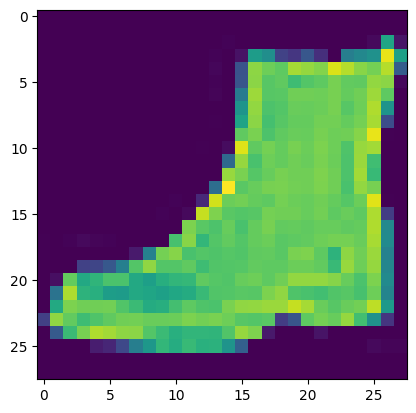

LABEL: 9
PREDICTION: 9


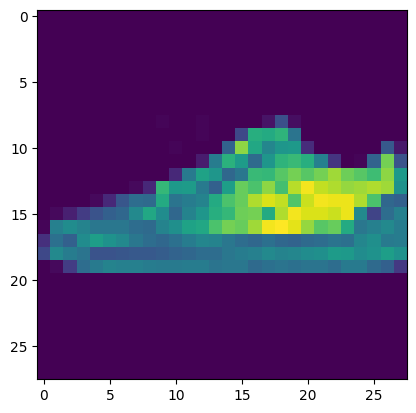

LABEL: 7
PREDICTION: 7


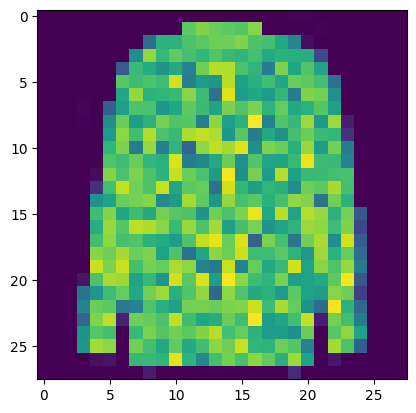

LABEL: 6
PREDICTION: 6


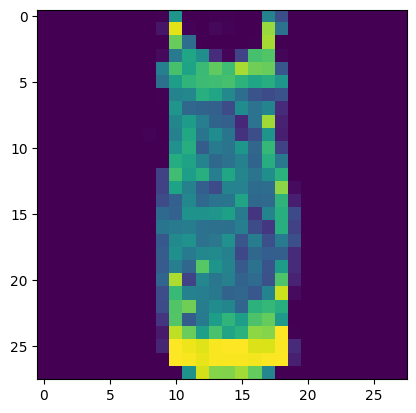

LABEL: 3
PREDICTION: 3


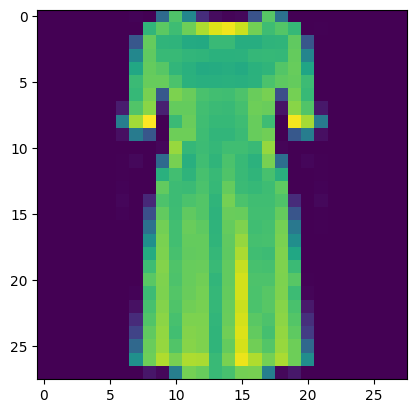

LABEL: 3
PREDICTION: 3


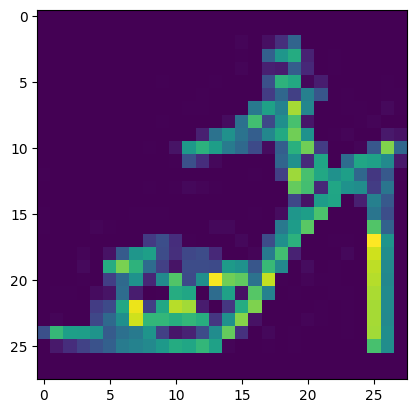

LABEL: 5
PREDICTION: 5


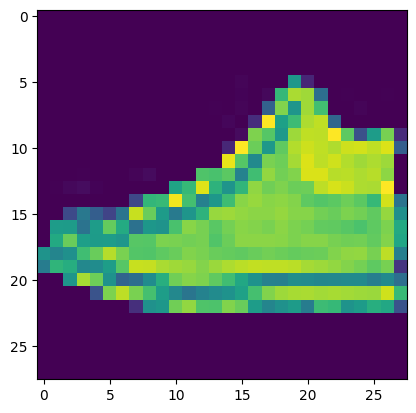

LABEL: 9
PREDICTION: 7
Misclassification detected. Analysis:


In [41]:
CHECKPOINT_FILE_PATH ='/Users/yangdongjae/Desktop/DeepLearning/link_dl-main/_02_homeworks/_03_fashion_mnist/checkpoints/GoogleNetAdam'

test_model = get_my_model()
classification_tester = ClassificationTester(
    'Fashion_MNIST', test_model, my_test_data_loader, my_f_mnist_transforms, CHECKPOINT_FILE_PATH
)

random_indices = random.sample(range(len(my_f_mnist_test_images)), 10)

for idx in random_indices:
    img, label = my_f_mnist_test_images[idx]
    plt.imshow(img)
    plt.show()
    print("LABEL:", label)


    img_tensor = torch.tensor(np.array(img)).unsqueeze(dim=0).unsqueeze(dim=0)


    output = classification_tester.test_single(img_tensor)
    print("PREDICTION:", output)


    if label != output:
        print("Misclassification detected. Analysis:")

# GoogleNet SGD 

In [42]:
def get_my_model():
    class InceptionModule(nn.Module):
        def __init__(self, in_channels):
            super(InceptionModule, self).__init__()

            
            self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=1)
            self.bn1 = nn.BatchNorm2d(64)

            
            self.conv3 = nn.Conv2d(in_channels, 128, kernel_size=3, padding=1)
            self.bn3 = nn.BatchNorm2d(128)

            
            self.conv5 = nn.Conv2d(in_channels, 32, kernel_size=5, padding=2)
            self.bn5 = nn.BatchNorm2d(32)

            
            self.pool = nn.MaxPool2d(3, stride=1, padding=1)
            self.conv_pool = nn.Conv2d(in_channels, 32, kernel_size=1)
            self.bn_pool = nn.BatchNorm2d(32)

        def forward(self, x):
            x1 = F.relu(self.bn1(self.conv1(x)))
            x3 = F.relu(self.bn3(self.conv3(x)))
            x5 = F.relu(self.bn5(self.conv5(x)))
            xp = F.relu(self.bn_pool(self.conv_pool(self.pool(x))))

            return torch.cat([x1, x3, x5, xp], dim=1)

    class MyGoogleNet(nn.Module):
        def __init__(self, num_classes):
            super(MyGoogleNet, self).__init__()
            self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
            self.bn1 = nn.BatchNorm2d(64)
            self.pool1 = nn.MaxPool2d(3, stride=2, padding=1)

            
            self.inception1 = InceptionModule(64)
            self.inception2 = InceptionModule(256)  

            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.fc = nn.Linear(256, num_classes)  

        def forward(self, x):
            x = F.relu(self.bn1(self.conv1(x)))
            x = self.pool1(x)
            x = self.inception1(x)
            x = self.inception2(x)
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)
            return x

    my_google_net = MyGoogleNet(10)
    return my_google_net


In [43]:
def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
    run_time_str = run_time_str + 'GOOGLENET_BN_ADAM'

    config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience
    }

    project_name = 'Fashion_MNIST'
    wandb.init(
        mode = "online" if args.wandb else "disabled",
        project = project_name,
        notes = "Assignment #3 with Fashion MNIST dataset",
        tags = ["ComputerVision", "ImageClassification","CNN"],
        name = run_time_str,
        config = config
    )

    print(args)
    print(wandb.config)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on Device {device}")

    train_data_loader, validation_data_loader, mnist_transforms = get_fashion_mnist_data()
    model = get_my_model()
    model.to(device)
    wandb.watch(model)

    optimizer = optim.SGD(model.parameters(), lr=wandb.config.learning_rate)

    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, mnist_transforms,
        run_time_str, wandb, device, checkpoint_file_path='/Users/yangdongjae/Desktop/DeepLearning/link_dl-main/_02_homeworks/_03_fashion_mnist/checkpoints/GoogleNetSGD'
    )

    classification_trainer.train_loop()

    wandb.finish()

In [44]:
model = get_my_model()
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,200
       BatchNorm2d-2           [-1, 64, 14, 14]             128
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4             [-1, 64, 7, 7]           4,160
       BatchNorm2d-5             [-1, 64, 7, 7]             128
            Conv2d-6            [-1, 128, 7, 7]          73,856
       BatchNorm2d-7            [-1, 128, 7, 7]             256
            Conv2d-8             [-1, 32, 7, 7]          51,232
       BatchNorm2d-9             [-1, 32, 7, 7]              64
        MaxPool2d-10             [-1, 64, 7, 7]               0
           Conv2d-11             [-1, 32, 7, 7]           2,080
      BatchNorm2d-12             [-1, 32, 7, 7]              64
  InceptionModule-13            [-1, 256, 7, 7]               0
           Conv2d-14             [-1, 6

In [45]:
model.eval()  
input_tensor = torch.tensor(np.array(my_f_mnist_test_images[0][0])).unsqueeze(dim=0).unsqueeze(dim=0).float()
dot = make_dot(model(input_tensor), params=dict(model.named_parameters()))
dot.render("GoogleNet_SGD", format="png")
model.train()  


MyGoogleNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception1): InceptionModule(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (conv_pool): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (bn_pool): BatchNorm2d(32, eps=1e-05, momentum=0.

![](./GoogleNet_SGD.png)

In [ ]:
parser = get_parser()
args,_ = parser.parse_known_args()
main(args)

MODEL FILE: /Users/yangdongjae/Desktop/DeepLearning/link_dl-main/_02_homeworks/_03_fashion_mnist/checkpoints/GoogleNetSGD/Fashion_MNIST_checkpoint_latest.pt


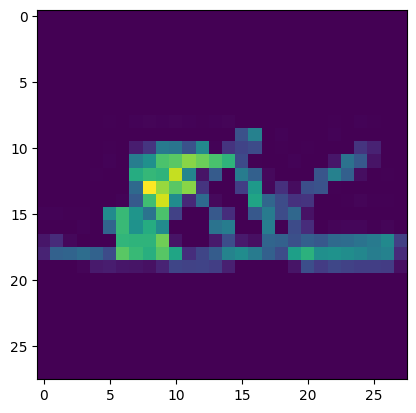

LABEL: 5
PREDICTION: 5


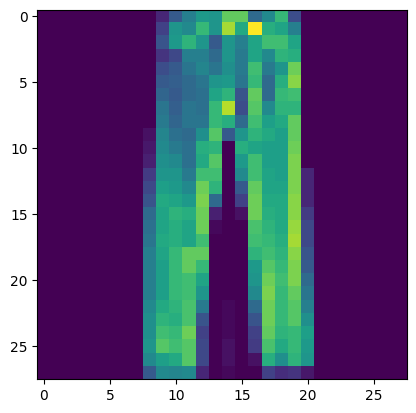

LABEL: 1
PREDICTION: 1


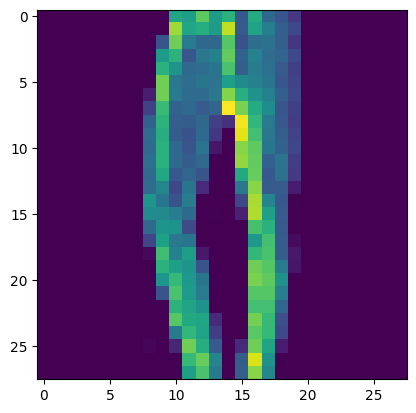

LABEL: 1
PREDICTION: 1


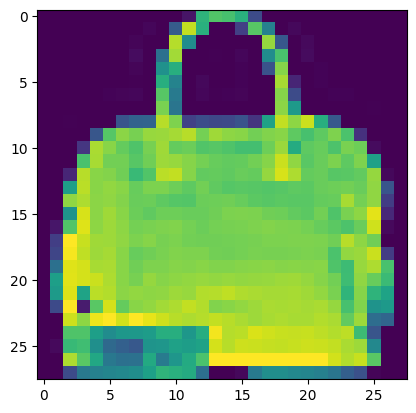

LABEL: 8
PREDICTION: 8


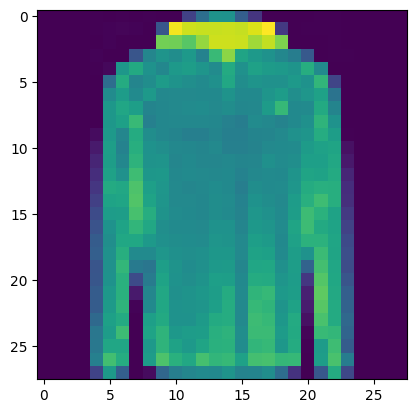

LABEL: 2
PREDICTION: 2


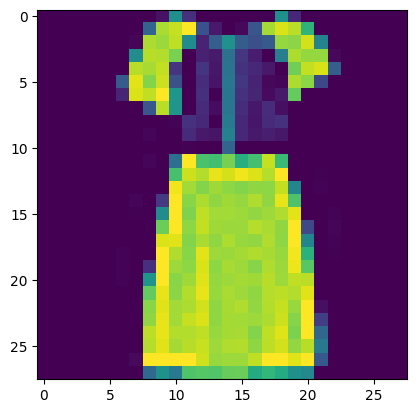

LABEL: 3
PREDICTION: 3


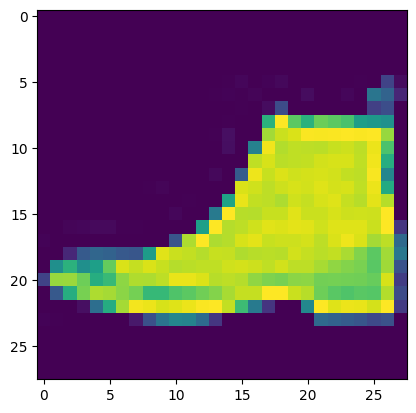

LABEL: 9
PREDICTION: 9


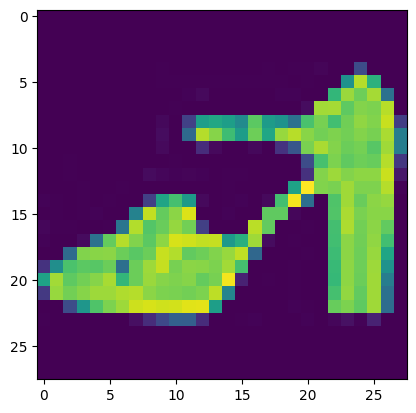

LABEL: 5
PREDICTION: 5


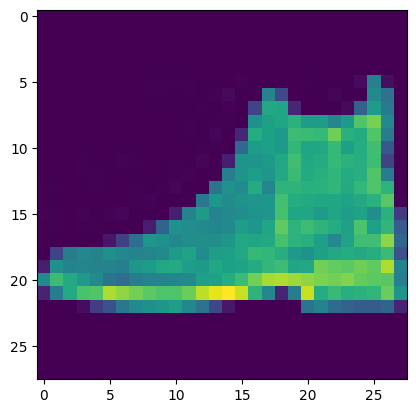

LABEL: 9
PREDICTION: 9


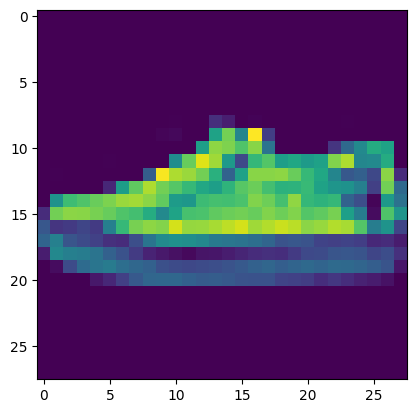

LABEL: 7
PREDICTION: 7


In [46]:
CHECKPOINT_FILE_PATH ='/Users/yangdongjae/Desktop/DeepLearning/link_dl-main/_02_homeworks/_03_fashion_mnist/checkpoints/GoogleNetSGD'

test_model = get_my_model()
classification_tester = ClassificationTester(
    'Fashion_MNIST', test_model, my_test_data_loader, my_f_mnist_transforms, CHECKPOINT_FILE_PATH
)

random_indices = random.sample(range(len(my_f_mnist_test_images)), 10)

for idx in random_indices:
    img, label = my_f_mnist_test_images[idx]
    plt.imshow(img)
    plt.show()
    print("LABEL:", label)


    img_tensor = torch.tensor(np.array(img)).unsqueeze(dim=0).unsqueeze(dim=0)


    output = classification_tester.test_single(img_tensor)
    print("PREDICTION:", output)


    if label != output:
        print("Misclassification detected. Analysis:")

# Result

![](./plot.png)